<a href="https://colab.research.google.com/github/sriyaamperayani/MealGram-Project/blob/main/MealGramProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# MealGram: AI-powered Image-Based Food Calorie Estimator
# CRISP-DM Methodology Implementation

# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

100%|██████████| 9.38G/9.38G [07:56<00:00, 21.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


Dataset info:
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train':

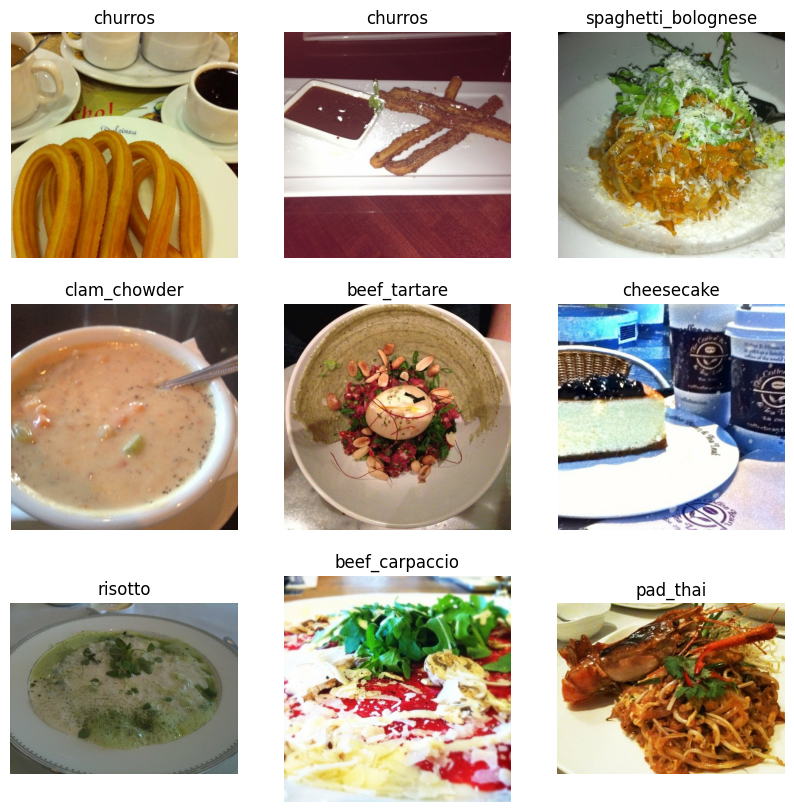

In [2]:
# Business Understanding
# Our main objective is to develop an accurate and user-friendly system for estimating
# calorie content from food images. This addresses the need for simplified calorie tracking
# to promote healthier eating habits.

# Key success criteria:
# - Model accuracy: 85% top-1 accuracy, 95% top-5 accuracy
# - Calorie estimation: Within ±20% error margin of standard references
# - User satisfaction: Positive feedback on app usability

# Data Understanding
# We'll use the Food-101 dataset as our primary data source.
# This dataset contains 101,000 images across 101 food categories.

# Load Food-101 dataset
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print("Dataset info:")
print(ds_info)

# Visualize a few sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(ds_info.features['label'].int2str(label))
    plt.axis('off')
plt.show()

In [3]:
# Data Preparation
# We'll preprocess the images and create a TensorFlow data pipeline

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_image(image, label):
    """Resize and preprocess the image."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# Save the processed datasets to TFRecord format or as numpy arrays.
train_images, train_labels = [], []
for images_batch, labels_batch in train_ds:
    train_images.append(images_batch.numpy())
    train_labels.append(labels_batch.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)

test_images, test_labels = [], []
for images_batch, labels_batch in test_ds:
    test_images.append(images_batch.numpy())
    test_labels.append(labels_batch.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

print("Datasets saved successfully.")

In [ ]:
# First, load the saved numpy arrays:
import numpy as np
import json

train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

# Create a dictionary with the dataset information:
dataset_info = {
    'name': 'food101',
    'description': 'Processed Food-101 dataset',
    'version': '1.0.0',
    'splits': {
        'train': {
            'num_examples': len(train_images),
            'file_name': 'train_images.npy'
        },
        'test': {
            'num_examples': len(test_images),
            'file_name': 'test_images.npy'
        }
    },
    'features': {
        'image': {
            'shape': list(train_images.shape[1:]),
            'dtype': str(train_images.dtype)
        },
        'label': {
            'num_classes': len(np.unique(train_labels)),
            'dtype': str(train_labels.dtype)
        }
    }
}

# Save the dataset information to dataset_info.json:
with open('dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print("Dataset information saved to dataset_info.json")

In [4]:
# Modeling
# We'll use transfer learning with MobileNetV2 as our base model

# Create the base model from the pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create the full model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 353,893 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 348s 128ms/step - accuracy: 0.1175 - loss: 3.9306 - top_5_accuracy: 0.3000 - val_accuracy: 0.1322 - val_loss: 6.2499 - val_top_5_accuracy: 0.3261
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 276s 116ms/step - accuracy: 0.3523 - loss: 2.6041 - top_5_accuracy: 0.6537 - val_accuracy: 0.1864 - val_loss: 5.2749 - val_top_5_accuracy: 0.4190
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 275s 116ms/step - accuracy: 0.4573 - loss: 2.1435 - top_5_accuracy: 0.7488 - val_accuracy: 0.3610 - val_loss: 2.8768 - val_top_5_accuracy: 0.6597
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 276s 116ms/step - accuracy: 0.5147 - loss: 1.8981 - top_5_accuracy: 0.7919 - val_accuracy: 0.3063 - val_loss: 3.4526 - val_top_5_accuracy: 0.5871
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 277s 117ms/step - accuracy: 0.5655 - loss: 1.6894 - top_5_accuracy: 0.8247 - val_accuracy: 0.3415 - val_loss: 3.3850 - val_top_5_accuracy: 0.6165
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 277s 117ms/step - 

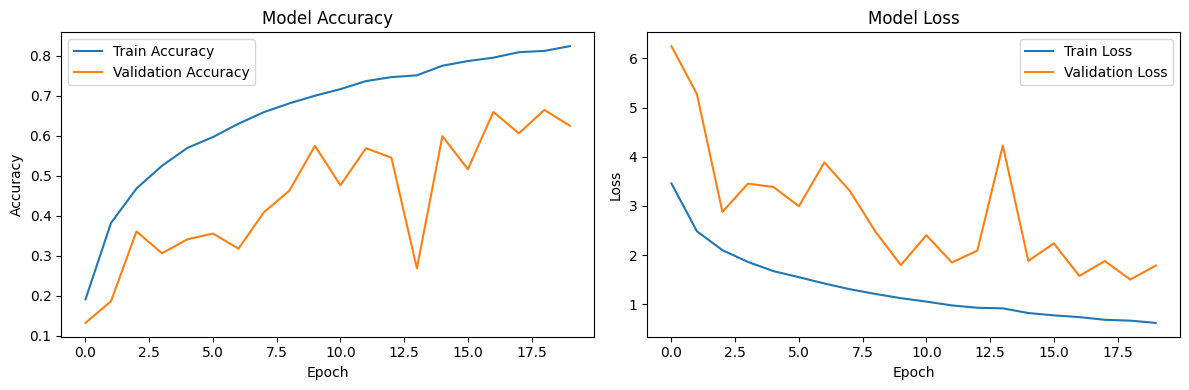

In [5]:
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Modified preprocess_image function
def preprocess_image(images, labels):
    """Resize and preprocess the image."""
    images = tf.image.resize(images, (IMG_SIZE, IMG_SIZE))
    images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
    return images, labels

# Apply the preprocessing to your datasets

(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Batch the datasets
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create and compile the model
model = tf.keras.Sequential([
    tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
])
# Use SparseTopKCategoricalAccuracy with k=5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[tensorboard_callback]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Save the trained model after the training process is complete
model.save('food_classification_model.h5')

790/790 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.6268 - loss: 1.7729 - top_5_accuracy: 0.8567
Test accuracy: 0.63
Test top-5 accuracy: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━

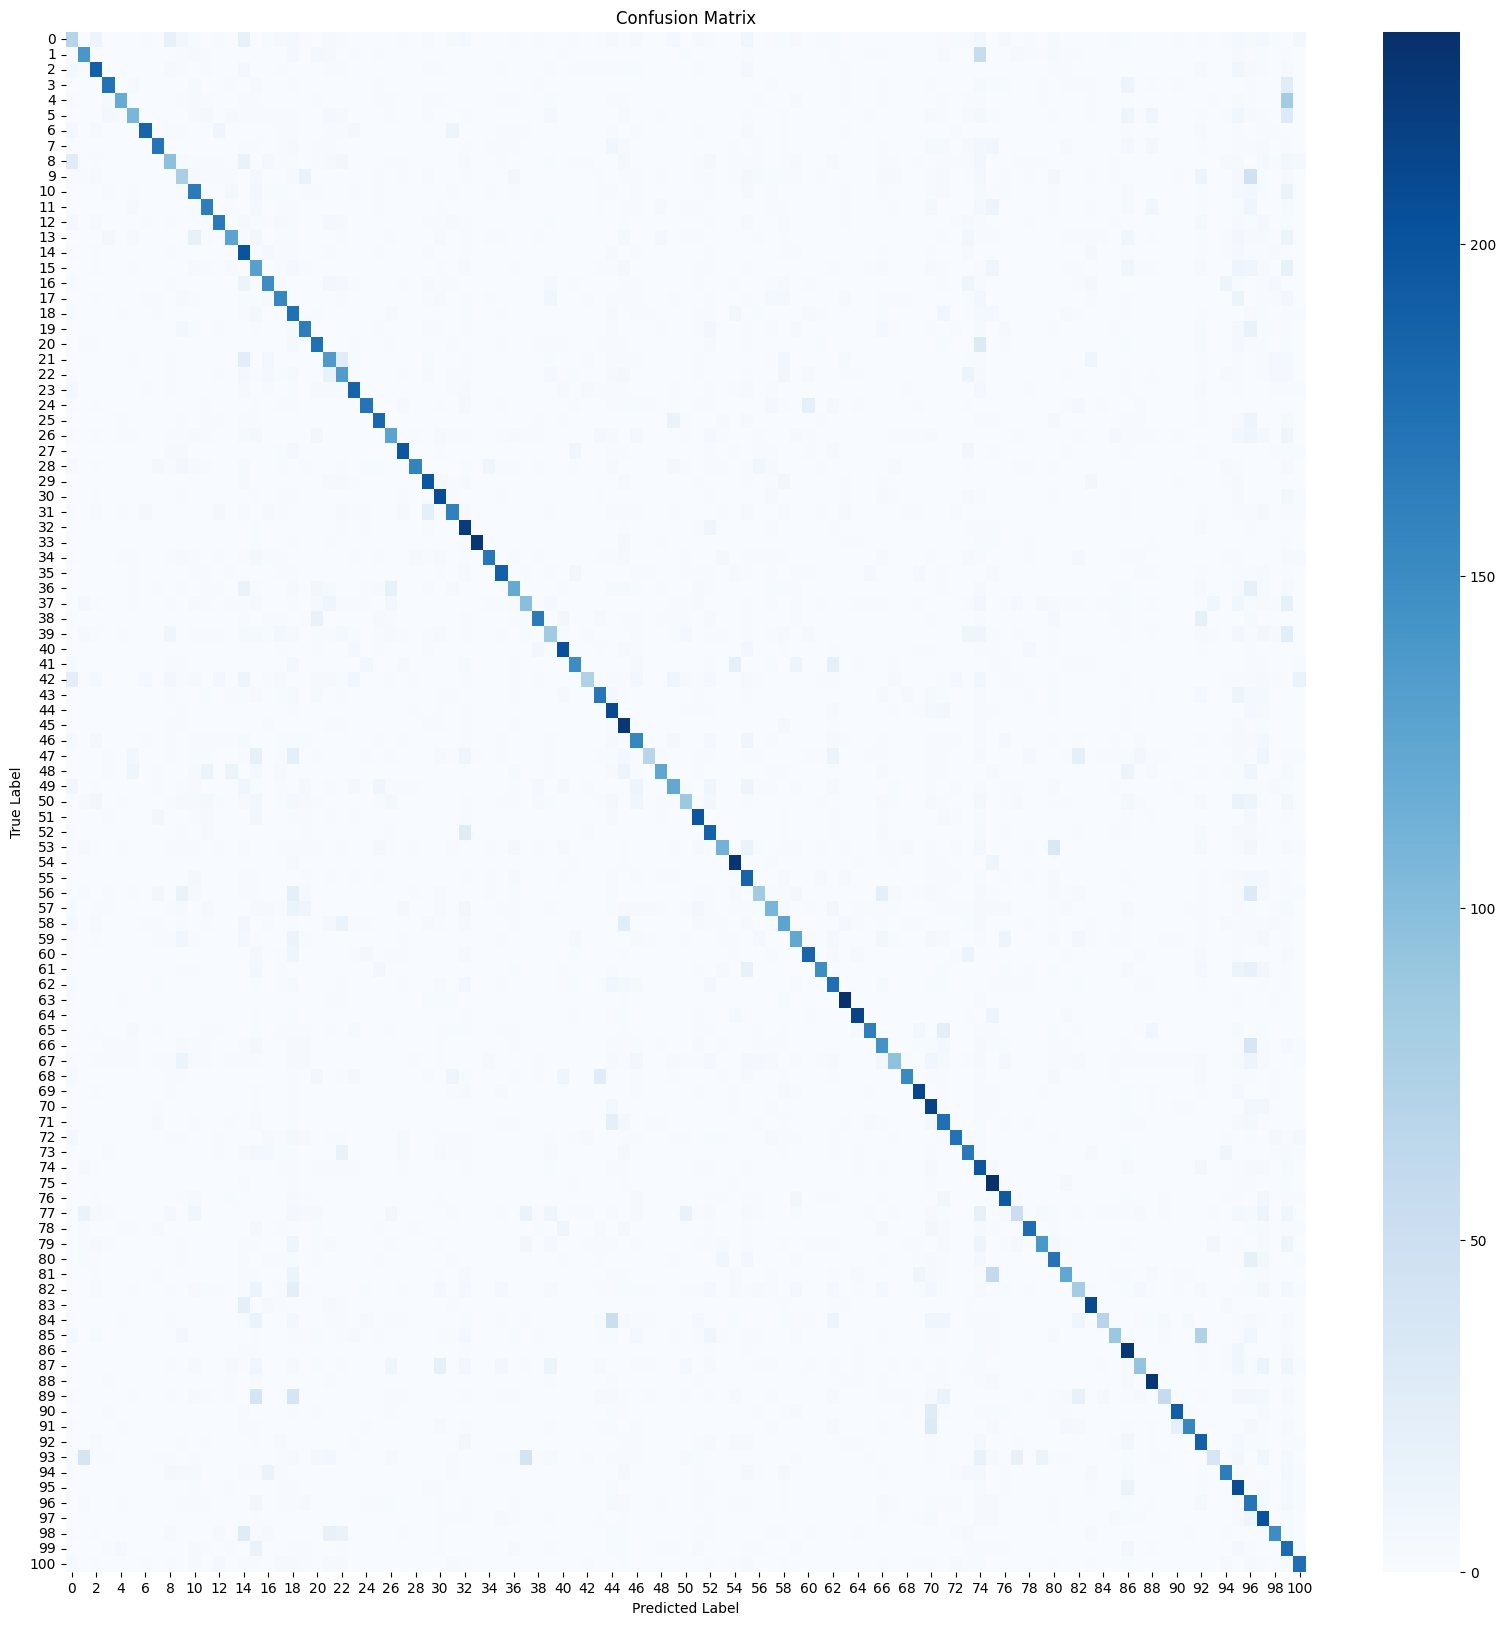

In [6]:
# Evaluation
# We'll evaluate the model's performance on the test set

test_loss, test_accuracy, test_top_5_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test top-5 accuracy: {test_top_5_accuracy:.2f}")

# Confusion Matrix
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    pred_batch = model.predict(image_batch)
    y_pred.extend(np.argmax(pred_batch, axis=1))
    y_true.extend(label_batch.numpy())

conf_mat = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# Model Interpretation
# We'll use Grad-CAM to visualize which parts of the image are important for classification

from tensorflow.keras.models import Model

# Create a Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Display Grad-CAM for a sample image
sample_image, sample_label = next(iter(test_ds))[0][0], next(iter(test_ds))[1][0]
img_array = np.expand_dims(sample_image, axis=0)

# Get the name of the last convolutional layer (example)
last_conv_layer_name = model.layers[-5].name  # Assuming MobileNetV2 structure

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()

# Superimpose heatmap on original image
import cv2

heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + sample_image

plt.imshow(superimposed_img / 255)
plt.title(f"True: {ds_info.features['label'].int2str(sample_label.numpy())}, Pred: {ds_info.features['label'].int2str(np.argmax(model.predict(img_array)[0]))}")
plt.axis('off')
plt.show()

ValueError: The layer sequential_1 has never been called and thus has no defined output.

In [12]:
# Calorie Estimation
# We'll create a simple calorie estimation function based on food type and portion size
# Note: This is a simplified example and would need to be expanded with a comprehensive database of food calorie content

def estimate_calories(food_class, portion_size):
    # Simplified calorie database (food_class: calories per 100g)
    calorie_db = {
        'apple_pie': 237,
        'pizza': 266,
        'french_fries': 312,
        'sushi': 150,
        'chicken_curry': 147,
    }

    if food_class in calorie_db:
        base_calories = calorie_db[food_class]
        estimated_calories = (base_calories / 100) * portion_size
        return estimated_calories
    else:
        return None

# Example usage
food_class = 'pizza'
portion_size = 200  # grams
estimated_calories = estimate_calories(food_class, portion_size)
print(f"Estimated calories for {portion_size}g of {food_class}: {estimated_calories:.0f} calories")

Estimated calories for 200g of pizza: 532 calories


In [26]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import io

# Load the model (assuming it's already trained and saved)
@st.cache_resource
def load_model():
    return tf.keras.models.load_model('food_classification_model.h5')

model = load_model()

# Constants
IMG_SIZE = 224

# Load dataset info
import json
with open('dataset_info.json', 'r') as f:
    ds_info = json.load(f)

def preprocess_image(image):
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def estimate_calories(food_class, portion_size):
    # Simplified calorie database (food_class: calories per 100g)
    calorie_db = {
        'apple_pie': 237,
        'pizza': 266,
        'french_fries': 312,
        'sushi': 150,
        'chicken_curry': 147,
    }

    if food_class in calorie_db:
        base_calories = calorie_db[food_class]
        estimated_calories = (base_calories / 100) * portion_size
        return estimated_calories
    else:
        return None

st.title('MealGram: AI-powered Food Calorie Estimator')

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    with st.spinner('Analyzing image...'):
        predictions = model.predict(processed_image)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    food_class = ds_info['features']['label']['names'][predicted_class]

    st.success(f"Predicted food: {food_class}")
    st.info(f"Confidence: {confidence:.2f}")

    # Calorie estimation
    portion_size = st.slider('Estimate portion size (in grams)', 50, 500, 100)
    estimated_calories = estimate_calories(food_class, portion_size)

    if estimated_calories:
        st.metric(label="Estimated Calories", value=f"{estimated_calories:.0f} calories")
    else:
        st.warning("Calorie information not available for this food item.")

    st.caption("Note: This is a simplified calorie estimation. For accurate dietary advice, please consult a nutritionist.")

# Feedback section
st.subheader("We'd love your feedback!")
user_rating = st.slider("How would you rate your experience?", 1, 5, 3)
user_feedback = st.text_area("Any additional comments or suggestions?")

if st.button("Submit Feedback"):
    st.success("Thank you for your feedback! We appreciate your input.")

# Instructions
st.sidebar.header("How to use MealGram")
st.sidebar.markdown("""
1. Upload a food image using the file uploader.
2. Wait for the AI to analyze and predict the food item.
3. Adjust the portion size using the slider.
4. View the estimated calorie count.
5. Provide feedback to help us improve!
""")

2024-12-13 04:28:52.320 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-13 04:28:52.367 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-13 04:28:52.368 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-13 04:28:52.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-13 04:28:52.870 Thread 'Thread-16': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-13 04:28:52.871 Thread 'Thread-16': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-13 04:28:53.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-13 04:28:53.158 Thread 'MainThread': miss

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())

In [ ]:
# Additional Considerations for Production Deployment

# 1. Model Versioning and A/B Testing
from mlflow import log_metric, log_param, log_artifact

# Log model parameters
log_param("model_architecture", "MobileNetV2")
log_param("input_shape", (IMG_SIZE, IMG_SIZE, 3))
log_param("num_classes", 101)

# Log model metrics
log_metric("test_accuracy", test_accuracy)
log_metric("test_top_5_accuracy", test_top_5_accuracy)

# Save and log the model
model.save('food_classification_model.h5')
log_artifact("food_classification_model.h5")

print("Model logged with MLflow")

# 2. Data Augmentation for Improved Generalization
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

# Apply data augmentation to the training dataset
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

print("Data augmentation applied to training dataset")

# 3. Model Optimization for Mobile Deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('food_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite model created for mobile deployment")

# 4. Continuous Integration / Continuous Deployment (CI/CD) Pipeline
# This would typically be set up in a separate configuration file (e.g., .gitlab-ci.yml or .github/workflows/main.yml)
# Here's a simplified example of what it might look like:

"""
stages:
  - train
  - test
  - deploy

train_model:
  stage: train
  script:
    - python train_model.py

run_tests:
  stage: test
  script:
    - python run_tests.py

deploy_to_production:
  stage: deploy
  script:
    - python deploy_model.py
  only:
    - master
"""

print("CI/CD pipeline configuration example shown")